In [12]:
import pandas as pd
import seaborn as sb
import numpy as np
from scipy.cluster.hierarchy import cut_tree
from scipy.stats import zscore
from scipy import stats
import matplotlib.pyplot as plt
import json
import csv
import re

In [13]:
#1. Load the following hypoxia dataset directly into your Jupyter Notebook as a pandas dataframe
df = pd.read_csv("hypoxiaDataset.complete.csv", header=0)
#df

In [14]:
#2.Generate a subsetted pandas dataframe containing genes with a: 
#o log2FoldChange >= 1 between 5-O2 and 0.1-O2. 
#o padj < 0.05. 
#Note that you will need to calculate the Log2FoldChange yourself.

#create the foldchange
df["log2FoldChange"] = np.log2((df["5-O2"] + 1) / (df["0.1-O2"] + 1))
#filter genes
filtered_df = df[(df["log2FoldChange"] >= 1) & (df["padj"] < 0.05)]
#print
#filtered_df

In [15]:
#3 Set the index of the data frame to the official gene symbol of the row. The official gene symbol is found in the 'Id' column. 
#Example: gene####_OGS. 
#Therefore, the index for the row “gene1002_Col4a4” should be set to “Col4a4”. 
filtered_df.index = filtered_df["Id"].str.split("_").str[1]
filtered_df = filtered_df.drop(columns="Id")
#filtered_df

In [16]:
#4.  Subset the data frame further by only selecting columns with replicates (with ‘-O2-n#’ in their name). 
#Therefore, the new data frame should have 8 columns (4 conditions with 2 replicates each). 
replicate_cols = filtered_df.columns[filtered_df.columns.str.contains("-O2-n")]
filtered_df_replicates = filtered_df[replicate_cols]
filtered_df_copy = filtered_df_replicates.copy()

/scratch/herrerak.2039741.0/ipykernel_560862/695797626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_replicates['cluster'] = 'NA' # create dummy column to add to


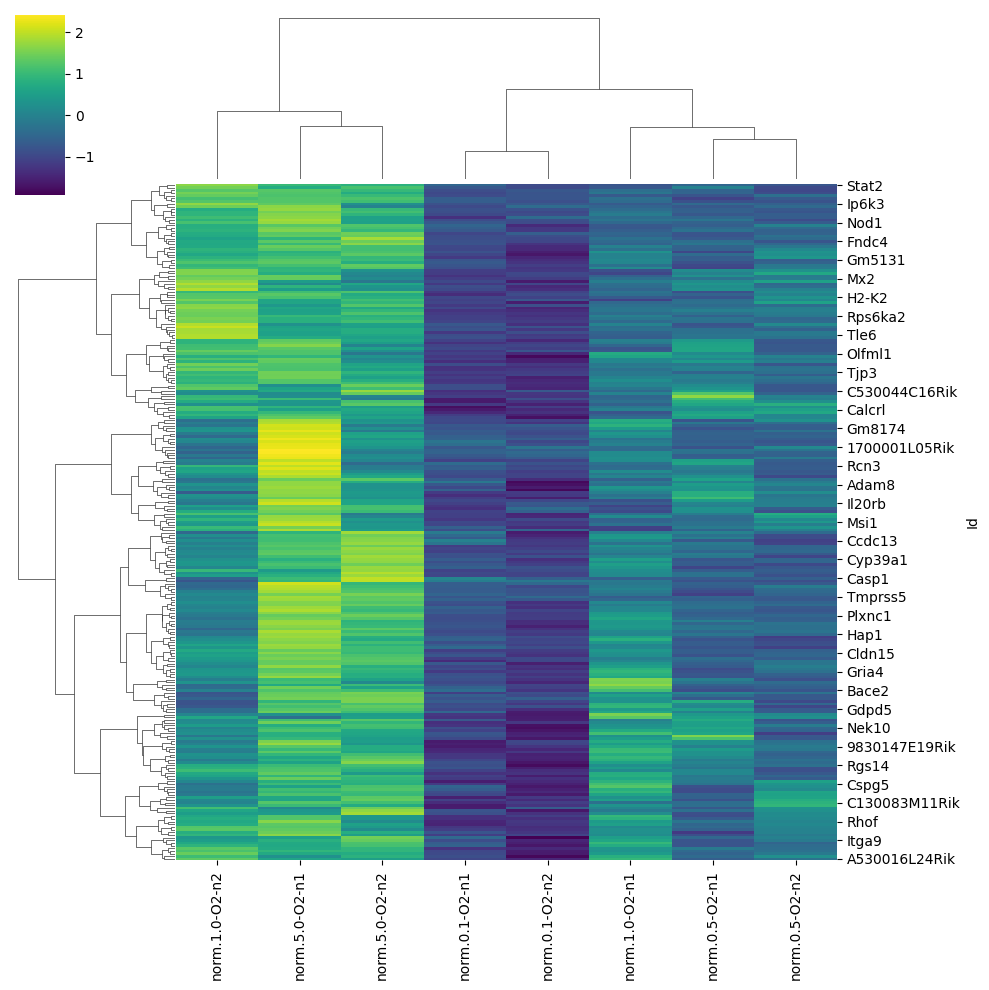

In [17]:
#5. Using your new data frame, plot a clustered heatmap using Z-score normalization and the “ward” clustering method with dendrograms. 
#Clustermap
heatmap = sb.clustermap(data=filtered_df_replicates, method="ward", z_score=0, cmap="viridis")
clusters = np.ravel(cut_tree(heatmap.dendrogram_row.linkage, n_clusters=6))
cluster_ids = dict(zip(filtered_df_replicates.index, clusters)) 
filtered_df_replicates['cluster'] = 'NA' # create dummy column to add to 
for k, v in cluster_ids.items(): 
    filtered_df_replicates.loc[k, 'cluster'] = v 

f = open('heatmap_data.csv', 'w') 
filtered_df_replicates.to_csv(f) 
f.close()

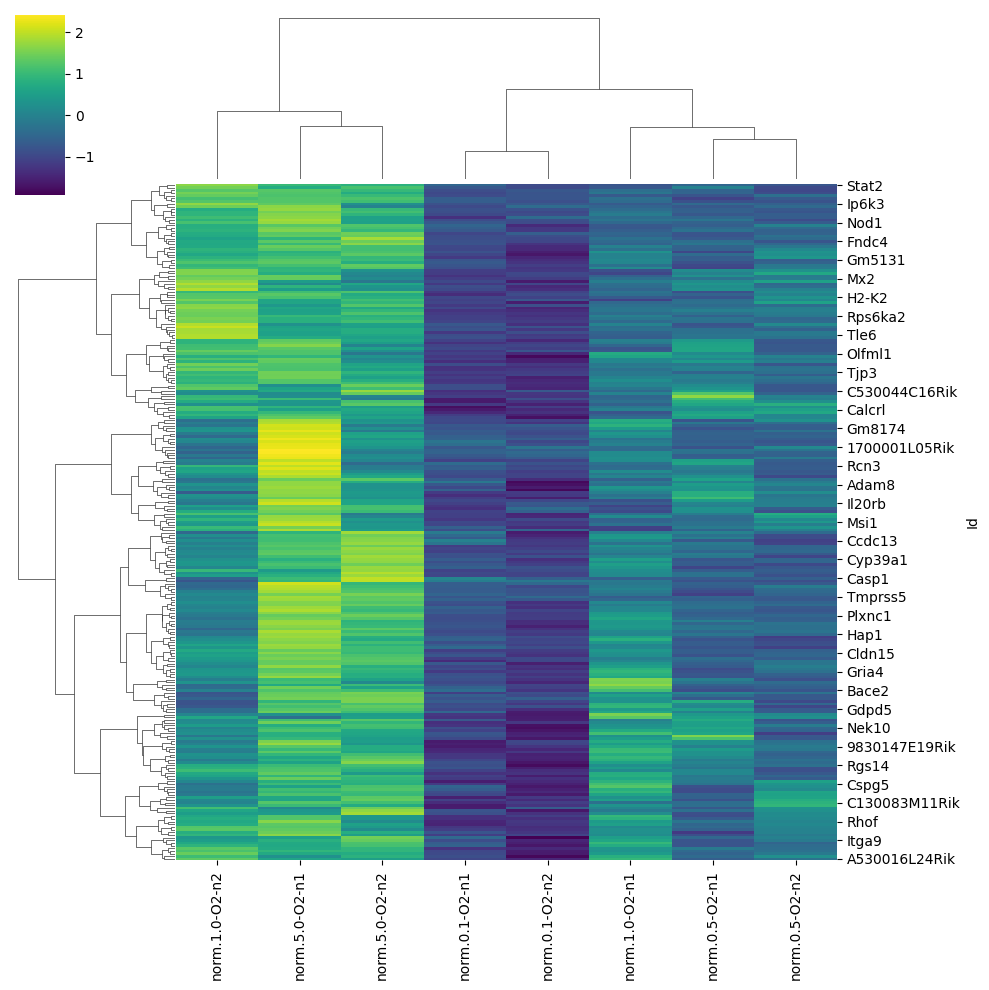

In [57]:
#6. Write a command to save the heatmap in a vectorized format (pdf, svg, etc...)
sb.clustermap(data=filtered_df_copy, method="ward", z_score=0, cmap="viridis")
plt.savefig("heatmap_and_dendogram.jpg")

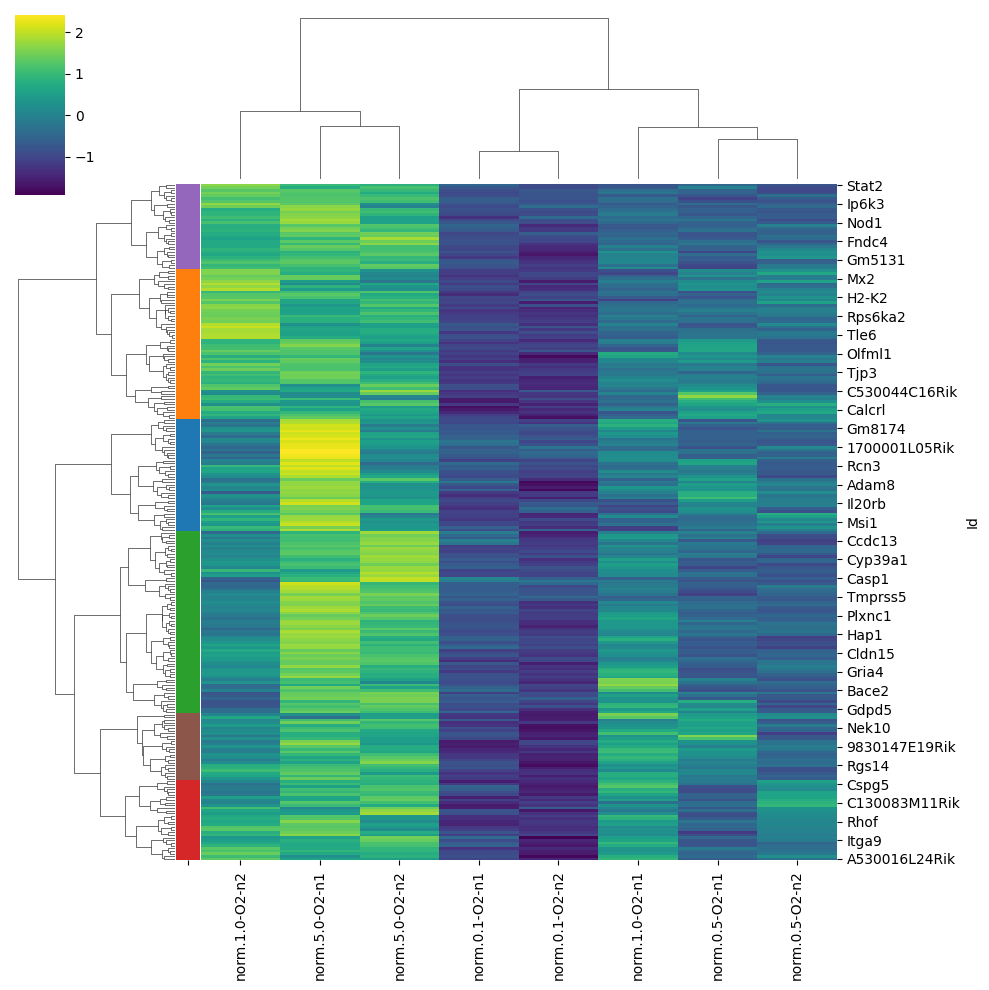

In [58]:
#7. Choose a cluster of genes that interests you and store their gene symbols in a list. 
#Justify your choice of cluster with a few sentences. 
rev_cluster_ids = {}
for k, v in cluster_ids.items():
    if v in rev_cluster_ids:
        rev_cluster_ids[v].append(k)
    else:
        rev_cluster_ids[v] = [k]

for k in rev_cluster_ids.keys():
    file_name = 'heatmap_data' + str(k) + '.txt'
    with open(file_name, 'w') as f:
        f.write('\n'.join(rev_cluster_ids[k]))

#I want to see how my clusters visually look, as it would help me to take a decision on my genes of interest.
data_for_clustering = filtered_df_replicates.drop(columns=["cluster"])
palette = sb.color_palette("tab10", n_colors=6)

clusters = np.ravel(cut_tree(heatmap.dendrogram_row.linkage, n_clusters=6))
row_colors = pd.Series(clusters, index=data_for_clustering.index).map(lambda x: palette[x])

# Graph again with cluster colors
heatmap = sb.clustermap(
    data_for_clustering,
    method="ward",
    z_score=0,
    cmap="viridis",
    row_colors=row_colors
)

plt.show()

#From what I can see, I'm most interested in the Cluster 0 (which is NOT the first one -purple- that you see, but the third one -blue-)
#I'm interested in that cluster as it is the one I think shows the greater variability between the z-values for each treatment.

In [59]:
#8 Using API    
import pandas as pd
import requests
from io import StringIO

In [60]:
#This is what we saw in class
url = "https://rest.uniprot.org/uniprotkb/search?query=organism_id:10090+AND+gene_exact:Gapdh+AND+reviewed:true&format=tsv"
all_fastas = requests.get(url).text
data_io = StringIO(all_fastas)
as_doc=pd.read_csv(data_io, sep="\t")
as_doc

,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,P16858,G3P_MOUSE,reviewed,Glyceraldehyde-3-phosphate dehydrogenase (GAPD...,Gapdh Gapd,Mus musculus (Mouse),333


In [61]:
#Here I wanted to see if it was possible to "separate" the url line
url = "https://rest.uniprot.org/uniprotkb/search?query=organism_id:10090""+AND+""reviewed:true&format=tsv"
all_fastas = requests.get(url).text
data_io = StringIO(all_fastas)
as_doc=pd.read_csv(data_io, sep="\t")
as_doc

,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,A0A5F8MPU3,CTSRT_MOUSE,reviewed,Cation channel sperm-associated targeting subu...,C2cd6 Als2cr11 CATSPERT,Mus musculus (Mouse),2282
1,A0A5K7RLP0,MEIOS_MOUSE,reviewed,Meiosis initiator protein,Meiosin Bhmg1,Mus musculus (Mouse),589
2,A0AAQ4VMX2,CO4A_MOUSE,reviewed,Complement C4-A (Sex-limited protein) [Cleaved...,C4a Slp,Mus musculus (Mouse),1734
3,A2A9F4,KDF1_MOUSE,reviewed,Keratinocyte differentiation factor 1,Kdf1,Mus musculus (Mouse),397
4,A2AC93,DNAI2_MOUSE,reviewed,Dynein axonemal intermediate chain 2 (Axonemal...,Dnai2 Dnaic2,Mus musculus (Mouse),623
5,A2AF47,DOC11_MOUSE,reviewed,Dedicator of cytokinesis protein 11 (Activated...,Dock11 Ziz2,Mus musculus (Mouse),2073
6,A2AGT5,CKAP5_MOUSE,reviewed,Cytoskeleton-associated protein 5,Ckap5,Mus musculus (Mouse),2032
7,A2AIP0,CMI2B_MOUSE,reviewed,Ciliary microtubule inner protein 2B,Cimip2b Fam166b,Mus musculus (Mouse),273
8,A2AIW0,ENTR1_MOUSE,reviewed,Endosome-associated-trafficking regulator 1 (S...,Entr1 Sdccag3,Mus musculus (Mouse),432
9,A2AJB7,LCN5_MOUSE,reviewed,Epididymal-specific lipocalin-5 (Epididymal re...,Lcn5 Mep10,Mus musculus (Mouse),192


In [62]:
#Here I wanted to see if it was possible to have the "gene_exact" separated from the URL
url = "https://rest.uniprot.org/uniprotkb/search?query=organism_id:10090""+AND+""gene_exact:Gapdh""+AND+""reviewed:true&format=tsv"
all_fastas = requests.get(url).text
data_io = StringIO(all_fastas)
data_io

In [63]:
#8 Using this list of official gene symbols, find their corresponding Uniprot ID. 
#For example, for the gene Gapdh, the script should return P16858. There are multiple ways to do this step. 
# Read the genes list (symbol per line)
with open("heatmap_data0.txt", "r") as f:
    genes = [line.strip() for line in f]

#I want to open an empty dictionary first:
gene_to_uniprot = {}
    
# Mapping each gen to the UniProt ID
for gene in genes:
    url = f"https://rest.uniprot.org/uniprotkb/search?query=gene_exact:{gene}+AND+organism_id:10090&fields=accession&format=tsv"
    response = requests.get(url)
    lines = response.text.strip().split('\n')
    
    if len(lines) > 1:
        uniprot_id = lines[1].strip()
    else:
        uniprot_id = "NA"
    
    gene_to_uniprot[gene] = uniprot_id

# Dictionary with results
for gene, uniprot_id in gene_to_uniprot.items():
    print(f"{gene} -> {uniprot_id}")

A3galt2 -> Q3V1N9
Ifnlr1 -> Q8CGK5
Msi1 -> Q61474
Oas1a -> P11928
Ncf1 -> Q09014
Nckap5 -> E9QAE1
Mgll -> O35678
Rcn3 -> Q8BH97
Adam8 -> Q05910
Ctxn1 -> Q8K129
Slc5a5 -> Q99PN0
Nfix -> P70257
Nlrc5 -> C3VPR6
Rltpr -> Q3V3V9
Prtg -> Q2EY15
Gm10639 -> E9Q6L7
Il20rb -> E9Q9A6
Gzmm -> O08643
Nlgn2 -> Q69ZK9
Serpinf2 -> Q61247
Gm8174 -> NA
Mroh6 -> V9GX81
1700001L05Rik -> Q3V153
Cntn1 -> P12960
Ddn -> Q80TS7
Efcab1 -> Q9D3N2
Ccdc116 -> Q80X53
Tmem44 -> Q8BR46
Parp14 -> Q2EMV9
Ephx3 -> Q3V1F8
Tmem151b -> Q68FE7
Hectd2 -> Q8CDU6
Cyp2c52-ps -> NA
Adra2a -> Q01338
Elf4 -> Q9Z2U4
Capn6 -> O35646
Slc40a1 -> Q9JHI9
Fhdc1 -> Q3ULZ2
Bglap2 -> P86547
Ctsk -> P55097
Itga10 -> E9Q6R1
Prex2 -> Q3LAC4


In [15]:
#Checking again the library
#gene_to_uniprot

In [64]:
#I wanted o see how much information I could get from each gene, and how was the "gene function" called in this ammount of information
#I used the Gadph mouse as an example.
uniprot_id = "P16858" 
url_test = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
response_test = requests.get(url_test)
data_test = response_test.json()
#data_test #I ran this but it was too many info. 
#I noticed that it is A LOT of information. So I created a table.

In [65]:
rows = []

for key, value in data_test.items():
    if isinstance(value, dict):
        subkeys = ", ".join(value.keys())
    else:
        subkeys = ""
    rows.append({"Main": key, "Sub items": subkeys})

df_keys = pd.DataFrame(rows)
#df_keys

In [66]:
#Part 2 of exploring that data in the tabl
features = data_test.get("features", [])
#features
#len(comments)
#types = set([c["type"] for c in features])
#types
#I don't think I need "features (for now)

In [67]:
#Here I'll explore that data in the table
comments = data_test.get("comments", [])
#comments
#len(comments)
types = set([c["commentType"] for c in comments])
types
# Yeyy! Function is here. 

{'ACTIVITY REGULATION',
 'CATALYTIC ACTIVITY',
 'DOMAIN',
 'FUNCTION',
 'INTERACTION',
 'PATHWAY',
 'PTM',
 'SIMILARITY',
 'SUBCELLULAR LOCATION',
 'SUBUNIT'}

In [68]:
function_comments = [c for c in comments if c.get("commentType") == "FUNCTION"]
#function_comments
#I see here are the protein functions I'm interested in. Now I need to see how to grab this.
for fc in function_comments:
    if "texts" in fc:
        for t in fc["texts"]:
            print(t.get("value", ""))
            
#With this I'm able to see that this function work for what I want to do. So I need to find a way to retreive it in a single line for all genes. 

Has both glyceraldehyde-3-phosphate dehydrogenase and nitrosylase activities, thereby playing a role in glycolysis and nuclear functions, respectively (PubMed:19903941). Glyceraldehyde-3-phosphate dehydrogenase is a key enzyme in glycolysis that catalyzes the first step of the pathway by converting D-glyceraldehyde 3-phosphate (G3P) into 3-phospho-D-glyceroyl phosphate (PubMed:19903941). Modulates the organization and assembly of the cytoskeleton (By similarity). Facilitates the CHP1-dependent microtubule and membrane associations through its ability to stimulate the binding of CHP1 to microtubules (By similarity). Component of the GAIT (gamma interferon-activated inhibitor of translation) complex which mediates interferon-gamma-induced transcript-selective translation inhibition in inflammation processes (PubMed:23071094). Upon interferon-gamma treatment assembles into the GAIT complex which binds to stem loop-containing GAIT elements in the 3'-UTR of diverse inflammatory mRNAs (such 

In [69]:
#9. Using the list of Uniprot IDs, collect gene function information for each gene. 
#Note that there are multiple ways to do this, all methods are accepted. 
#The gene function should be accessible through either the gene name or Uniprot ID.

# I like it more when data is in tables. So I'm creating a table for this. 
#I'm starting with the output rows that I'll be using as headers. 
output_rows = [("Gene", "UniProt_ID", "Function")]

# Obtaining the function in Uniprot
for gene, uniprot_id in gene_to_uniprot.items():
    if uniprot_id == "NA":
        function = "NA"
    else:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.txt"
        response = requests.get(url)
        if response.status_code: #I found how to use this here https://pdbeurope.github.io/api-webinars/webinars/web2/7_PDB_sequence_search.html
            lines = response.text.split('\n')
            function_lines = []
            capture = False
            for line in lines:
                #if line.startswith("CC"): #If I only add "CC" as I did in the beginning, I get the whole function script. I just want the function, so I add "CC   -!- FUNCTION:" from copypasting it 
                    #from my last results.
                if line.startswith("CC   -!- FUNCTION:"):
                    capture = True
                    function_lines.append(line.replace("CC   -!- FUNCTION:", "").strip())
                elif capture and line.startswith("CC   -!- FUNCTION:"):
                    function_lines.append(line.replace("CC   -!- FUNCTION:").strip())
                elif capture:
                    break
            function = " ".join(function_lines) if function_lines else "NA"
        else:
            function = "NA"
    
    output_rows.append((gene, uniprot_id, function))

with open("gene_function_info.tsv", "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerows(output_rows)


In [77]:
#10. Output a CSV (or better, a TSV) file where the first column is the original official gene symbol used, 
#the second is the collected Uniprot ID, and the rest contains additional information from the Uniprot record. 
#Additional information can include sequence length, protein mass, subcellular localization, etc...
#Whatever you deem useful. Your code should save the TSV when executed. 

output_rows = [("Gene", "UniProt_ID", "Function", "Sequence_length", "Protein_mass", "Subcellular_location")]

for gene, uniprot_id in gene_to_uniprot.items():
    if uniprot_id == "NA":
        function = sequence_length = protein_mass = subcellular_location = "NA"
    else:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.txt"
        response = requests.get(url)

        if response.status_code == 200:
            lines = response.text.split('\n')
            function_lines = []
            capture_function = False
            sequence_length = protein_mass = subcellular_location = "NA"

            for line in lines:
                if line.startswith("CC   -!- FUNCTION:"):
                    capture_function = True
                    function_lines.append(line.replace("CC   -!- FUNCTION:", "").strip())
                elif capture_function and line.startswith("CC       "):
                    function_lines.append(line.replace("CC       ", "").strip())
                elif capture_function:
                    capture_function = False

                elif line.startswith("SQ   SEQUENCE"):
                    match = re.search(r"(\d+)\s+AA;\s+([\d,]+)\s+MW;", line)
                    if match:
                        sequence_length = match.group(1)
                        protein_mass = match.group(2)

                elif line.startswith("CC   -!- SUBCELLULAR LOCATION:"):
                    subcellular_location = line.replace("CC   -!- SUBCELLULAR LOCATION:", "").strip()

            function = " ".join(function_lines) if function_lines else "NA"
        else:
            function = sequence_length = protein_mass = subcellular_location = "NA"

    output_rows.append((gene, uniprot_id, function, sequence_length, protein_mass, subcellular_location))

# Export
with open("gene_info_full.tsv", "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerows(output_rows)
